In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import matplotlib.dates as mdates
import seaborn as sns
import numpy as np
from collections import OrderedDict
plt.style.use('ggplot')

mql = pd.read_csv('data/olist_marketing_qualified_leads_dataset.csv')
closed_deals = pd.read_csv('data/olist_closed_deals_dataset.csv')

## EDA
- checking missing values

In [2]:
print("Marketing Qualified lead Dataset:")
print(mql.isnull().sum())
print()
print("Closed Deals Dataset:")
print(closed_deals.isnull().sum())

Marketing Qualified lead Dataset:
mql_id                 0
first_contact_date     0
landing_page_id        0
origin                60
dtype: int64

Closed Deals Dataset:
mql_id                             0
seller_id                          0
sdr_id                             0
sr_id                              0
won_date                           0
business_segment                   1
lead_type                          6
lead_behaviour_profile           177
has_company                      779
has_gtin                         778
average_stock                    776
business_type                     10
declared_product_catalog_size    773
declared_monthly_revenue           0
dtype: int64


- Will look into the missing values for both datasets
    - purpose: investigate whether there is any patterns to these rows with missing values

### MQL Dataset:

In [3]:
mql.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   mql_id              8000 non-null   object
 1   first_contact_date  8000 non-null   object
 2   landing_page_id     8000 non-null   object
 3   origin              7940 non-null   object
dtypes: object(4)
memory usage: 250.1+ KB


In [4]:
# change to datetime for later manipulation
mql['first_contact_date'] = pd.to_datetime(mql['first_contact_date'])

In [5]:
# looking at the most frequent landing page ids
mql.loc[mql['origin'].isnull()]['landing_page_id'].value_counts()[0:10]

22c29808c4f815213303f8933030604c    5
d41d8cd98f00b204e9800998ecf8427e    4
0c83f57c786a0b4a39efab23731c7ebc    4
b3346ddd5d7b2edda306d8f531e58660    3
58326e62183c14b0c03085c33b9fdc44    3
1e884e3078d9978e216a027ecd57fb34    2
6b6c0934205e87702519d1cce24055f9    2
21a104c3279681d9856b8a48723c4fee    1
3cd2a8301d5395f21cdd3094c9eaa2f4    1
99b00c6e27db383d844d1763dbcbfe06    1
Name: landing_page_id, dtype: int64

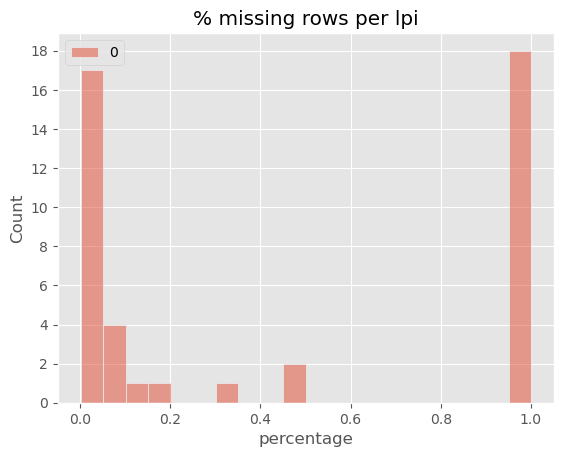

In [6]:
# check if the missing values are associated with landing page by:
# computing the percentage of (missing rows)/(total rows) of specific landing pages
missing_lp = mql.loc[mql['origin'].isnull()]['landing_page_id'].value_counts()
faulty_lp_perc = []
for i in missing_lp.index:
    total = mql.loc[mql['landing_page_id']==i].shape[0]
    faulty_lp_perc.append([missing_lp[i]/total])
sns.histplot(data=np.array(faulty_lp_perc), bins=10,binwidth=0.05)
plt.xlabel('percentage')
plt.yticks(ticks=range(0,19,2))
plt.title("% missing rows per lpi")
plt.show()

In [7]:
# checking how many landing page only had a single entry
# if there are significantly less than 18 landing pages with single entries, this could mean that certain landing pages may have problems
print(missing_lp.shape)
print()
print(missing_lp[missing_lp==1].shape)

(44,)

(37,)


- this means all 18 counts of 100% (i.e., 1.0) are landing pages with only one row
- this suggest there's not a specific cohort of landing pages that have majority missing rows 

In [8]:
# For analyzing first_contact_date, I will check monthly trends in the data (missing / overall)
mql['month'] = mql['first_contact_date'].dt.to_period("M")
monthly_stats = mql.groupby('month').count()
monthly_stats

,mql_id,first_contact_date,landing_page_id,origin
month,,,,
2017-06,4,4,4,3
2017-07,239,239,239,234
2017-08,386,386,386,385
2017-09,312,312,312,312
2017-10,416,416,416,415
2017-11,445,445,445,444
2017-12,200,200,200,197
2018-01,1141,1141,1141,1136
2018-02,1028,1028,1028,1021


In [9]:
# checking if missing values are associated with first_contact_date
missing_origin = mql.loc[mql['origin'].isnull()]
missing_monthly_stats = missing_origin.groupby('month').count()
missing_monthly_stats

,mql_id,first_contact_date,landing_page_id,origin
month,,,,
2017-06,1,1,1,0
2017-07,5,5,5,0
2017-08,1,1,1,0
2017-10,1,1,1,0
2017-11,1,1,1,0
2017-12,3,3,3,0
2018-01,5,5,5,0
2018-02,7,7,7,0
2018-03,9,9,9,0


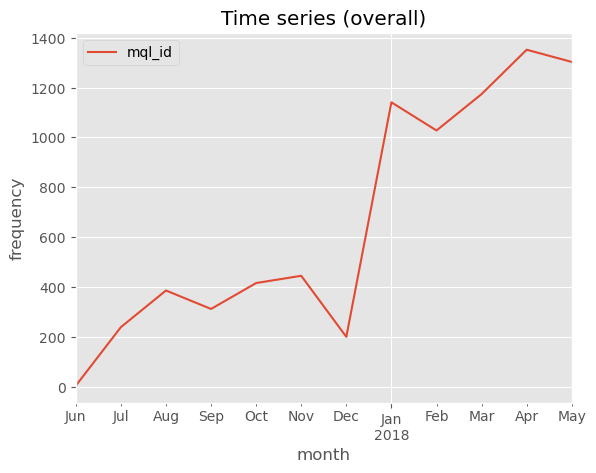

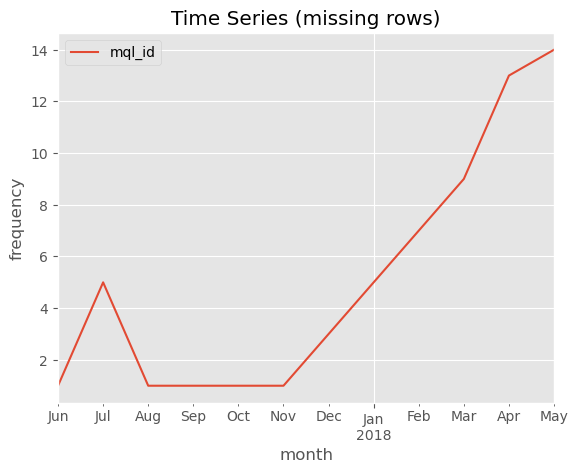

In [10]:
# visualizing results
monthly_stats.plot(y="mql_id")
plt.title("Time series (overall)")
plt.ylabel("frequency")
missing_monthly_stats.plot(y='mql_id')
plt.title("Time Series (missing rows)")
plt.ylabel("frequency")
plt.show()

- Both trends are very similar. There is an uptick in counts in 2018
- Since, this is present in trends including the total dataset and the subset of missing rows, the missing rows do not represent anything indicative
- NOTE: Since, `mql_id` is unique, it is irrelevant in this case

### Closed Deals Dataset:

In [11]:
closed_deals.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 842 entries, 0 to 841
Data columns (total 14 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   mql_id                         842 non-null    object 
 1   seller_id                      842 non-null    object 
 2   sdr_id                         842 non-null    object 
 3   sr_id                          842 non-null    object 
 4   won_date                       842 non-null    object 
 5   business_segment               841 non-null    object 
 6   lead_type                      836 non-null    object 
 7   lead_behaviour_profile         665 non-null    object 
 8   has_company                    63 non-null     object 
 9   has_gtin                       64 non-null     object 
 10  average_stock                  66 non-null     object 
 11  business_type                  832 non-null    object 
 12  declared_product_catalog_size  69 non-null     flo

In [12]:
# convert to datetime and add month label for time series analysis
closed_deals['won_date'] = pd.to_datetime(closed_deals['won_date'])
closed_deals['month'] = closed_deals['won_date'].dt.to_period("M")

In [13]:
closed_deals.isnull().sum()

mql_id                             0
seller_id                          0
sdr_id                             0
sr_id                              0
won_date                           0
business_segment                   1
lead_type                          6
lead_behaviour_profile           177
has_company                      779
has_gtin                         778
average_stock                    776
business_type                     10
declared_product_catalog_size    773
declared_monthly_revenue           0
month                              0
dtype: int64

In [14]:
779/842

0.9251781472684085

- 92.5% (779/842) of sellers do not own a company


In [15]:
# subset of dataset with no missing values
no_missing = closed_deals.loc[closed_deals.notnull().all(axis=1),:]
no_missing.head()

,mql_id,seller_id,sdr_id,sr_id,won_date,business_segment,lead_type,lead_behaviour_profile,has_company,has_gtin,average_stock,business_type,declared_product_catalog_size,declared_monthly_revenue,month
41,20fcec0873b39b4df3df34140d77d6e7,cee3c487c56d29554a22d112af618301,084b6fbb10729ed4da8c3d3f5a3ae7c9,0a0fb2b07d841f84fb6714e35c723075,2018-11-14 18:04:19,other,other,cat,False,False,1-5,other,120.0,6000.0,2018-11
70,58caf27a48e7930aefd5437298d64a70,922f6795c9e65f2485d4e63af76586ff,45749fb708130f78d0db07d8d80f030b,34d40cdaf94010a1d05b0d6212f9e909,2018-09-21 18:18:15,bed_bath_table,online_medium,"cat, wolf",True,True,5-20,reseller,50.0,30000.0,2018-09
86,4ddc45a9de1065695a90e87be37471c0,9d590e1df0faffd9ceaa1f0f0ea9af2f,e7dff61b78bebffa71678e126ce669ad,2695de1affa7750089c0455f8ce27021,2018-09-21 18:49:49,audio_video_electronics,online_medium,wolf,True,True,5-20,reseller,50.0,0.0,2018-09
119,d768d7e09a6f9ff4146a1659635cf304,f233b575e585413f12fe2f847d922447,282f16e20d50cb18d05182e80f6b9dd6,d3d1e91a157ea7f90548eef82f1955e3,2018-10-30 18:21:05,household_utilities,online_big,wolf,True,False,1-5,reseller,100.0,150000.0,2018-10
130,288ba9abad93ef50e6a76089ae84aab3,a8fee0ab6206634206f782c32e41a2a4,e7dff61b78bebffa71678e126ce669ad,4b339f9567d060bcea4f5136b9f5949e,2018-08-23 12:46:40,health_beauty,online_medium,cat,True,True,50-200,reseller,300.0,25000.0,2018-08


In [16]:
# looking at rows with missing values in (has_company), which has the largest amount of missing values
closed_deals.loc[closed_deals['has_company'].isnull()].isnull().sum()

mql_id                             0
seller_id                          0
sdr_id                             0
sr_id                              0
won_date                           0
business_segment                   1
lead_type                          6
lead_behaviour_profile           177
has_company                      779
has_gtin                         776
average_stock                    770
business_type                     10
declared_product_catalog_size    756
declared_monthly_revenue           0
month                              0
dtype: int64

In [17]:
missing_company = closed_deals.loc[closed_deals['has_company'].isnull()]
missing_company.head()

,mql_id,seller_id,sdr_id,sr_id,won_date,business_segment,lead_type,lead_behaviour_profile,has_company,has_gtin,average_stock,business_type,declared_product_catalog_size,declared_monthly_revenue,month
0,5420aad7fec3549a85876ba1c529bd84,2c43fb513632d29b3b58df74816f1b06,a8387c01a09e99ce014107505b92388c,4ef15afb4b2723d8f3d81e51ec7afefe,2018-02-26 19:58:54,pet,online_medium,cat,NaN,NaN,NaN,reseller,NaN,0.0,2018-02
1,a555fb36b9368110ede0f043dfc3b9a0,bbb7d7893a450660432ea6652310ebb7,09285259593c61296eef10c734121d5b,d3d1e91a157ea7f90548eef82f1955e3,2018-05-08 20:17:59,car_accessories,industry,eagle,NaN,NaN,NaN,reseller,NaN,0.0,2018-05
2,327174d3648a2d047e8940d7d15204ca,612170e34b97004b3ba37eae81836b4c,b90f87164b5f8c2cfa5c8572834dbe3f,6565aa9ce3178a5caf6171827af3a9ba,2018-06-05 17:27:23,home_appliances,online_big,cat,NaN,NaN,NaN,reseller,NaN,0.0,2018-06
3,f5fee8f7da74f4887f5bcae2bafb6dd6,21e1781e36faf92725dde4730a88ca0f,56bf83c4bb35763a51c2baab501b4c67,d3d1e91a157ea7f90548eef82f1955e3,2018-01-17 13:51:03,food_drink,online_small,NaN,NaN,NaN,NaN,reseller,NaN,0.0,2018-01
4,ffe640179b554e295c167a2f6be528e0,ed8cb7b190ceb6067227478e48cf8dde,4b339f9567d060bcea4f5136b9f5949e,d3d1e91a157ea7f90548eef82f1955e3,2018-07-03 20:17:45,home_appliances,industry,wolf,NaN,NaN,NaN,manufacturer,NaN,0.0,2018-07


In [18]:
# rows, with missing values, but not in the 'has_company' column
closed_deals.loc[closed_deals['has_company'].isnull()==False].isnull().sum()

mql_id                            0
seller_id                         0
sdr_id                            0
sr_id                             0
won_date                          0
business_segment                  0
lead_type                         0
lead_behaviour_profile            0
has_company                       0
has_gtin                          2
average_stock                     6
business_type                     0
declared_product_catalog_size    17
declared_monthly_revenue          0
month                             0
dtype: int64

In [19]:
# checking those rows 
missing_other = closed_deals.loc[closed_deals['has_company'].isnull()==False]
missing_other[missing_other['declared_product_catalog_size'].isnull()].head()

,mql_id,seller_id,sdr_id,sr_id,won_date,business_segment,lead_type,lead_behaviour_profile,has_company,has_gtin,average_stock,business_type,declared_product_catalog_size,declared_monthly_revenue,month
30,4bb1ec1ff58ad39558e8468054bfc469,4fae87d32467e18eb46e4a76a0a0b9ce,9d12ef1a7eca3ec58c545c678af7869c,a8387c01a09e99ce014107505b92388c,2018-07-19 18:06:07,small_appliances,online_medium,cat,True,True,20-50,reseller,NaN,0.0,2018-07
97,1e2a84cd1c6fcd7b7a07f49f1cf7f6cc,f4009c6b30765309a251c26bc458e0e5,e7dff61b78bebffa71678e126ce669ad,9ae085775a198122c5586fa830ff7f2b,2018-08-07 19:47:27,stationery,industry,"eagle, wolf",True,True,200+,reseller,NaN,0.0,2018-08
164,f49a02e0f135ae9f2bcf60f55bcd0174,f212a20c700f5a7c3d4de5ef38e02c42,370c9f455f93a9a96cbe9bea48e70033,d3d1e91a157ea7f90548eef82f1955e3,2018-08-10 13:01:03,audio_video_electronics,online_medium,cat,True,True,50-200,reseller,NaN,0.0,2018-08
179,e2e57ded5b59a2058dd5855564c6b5ea,160851d3ece7aa1a510f8d1a4bb8a8af,b90f87164b5f8c2cfa5c8572834dbe3f,4b339f9567d060bcea4f5136b9f5949e,2018-07-18 20:24:28,construction_tools_house_garden,industry,cat,True,True,200+,manufacturer,NaN,0.0,2018-07
203,3172362312fcf09d96f02125f66b74f5,fa7cc273072520346449b9e89329768a,0a0fb2b07d841f84fb6714e35c723075,34d40cdaf94010a1d05b0d6212f9e909,2018-08-10 16:46:39,audio_video_electronics,online_beginner,cat,True,True,200+,reseller,NaN,0.0,2018-08


Compare descriptive statistiscs between (specifically distribution of values of numeric columns)
- missing rows without/with company
- rows with/without missing values

Visualization:
- numeric columns: `declared_product_catalog_size`, `declared_monthly_revenue` (histogram)
- date column: `won_date` (time series)
- catalog column: `business_segment`, `lead_type`, `lead_behaviour_profile`, `business_type` (top 10 value counts)

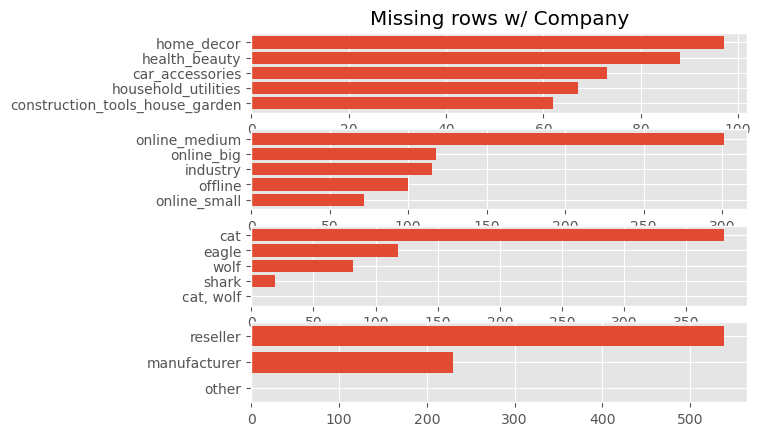

In [20]:
# Plots of top 5 most frequent for business segment, lead_type, lead_behaviour_profile, business_type
plt.subplot(4,1,1)
plt.barh(y=missing_company['business_segment'].value_counts()[:5][::-1].index, width=missing_company['business_segment'].value_counts()[:5][::-1])
plt.title("Missing rows w/ Company")
plt.subplot(4,1,2)
plt.barh(y=missing_company['lead_type'].value_counts()[:5][::-1].index, width=missing_company['lead_type'].value_counts()[:5][::-1])
plt.subplot(4,1,3)
plt.barh(y=missing_company['lead_behaviour_profile'].value_counts()[:5][::-1].index, width=missing_company['lead_behaviour_profile'].value_counts()[:5][::-1])
plt.subplot(4,1,4)
plt.barh(y=missing_company['business_type'].value_counts()[:5][::-1].index, width=missing_company['business_type'].value_counts()[:5][::-1])
plt.show()

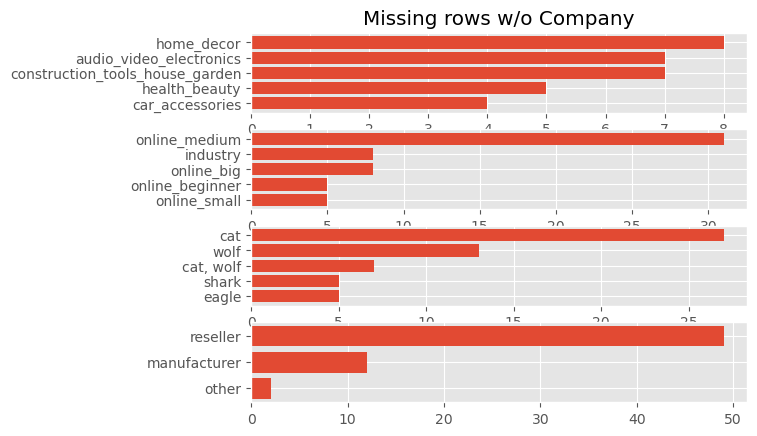

In [21]:
# Plots of top 5 most frequent for business segment, lead_type, lead_behaviour_profile, business_type
plt.subplot(4,1,1)
plt.barh(y=missing_other['business_segment'].value_counts()[:5][::-1].index, width=missing_other['business_segment'].value_counts()[:5][::-1])
plt.title("Missing rows w/o Company")
plt.subplot(4,1,2)
plt.barh(y=missing_other['lead_type'].value_counts()[:5][::-1].index, width=missing_other['lead_type'].value_counts()[:5][::-1])
plt.subplot(4,1,3)
plt.barh(y=missing_other['lead_behaviour_profile'].value_counts()[:5][::-1].index, width=missing_other['lead_behaviour_profile'].value_counts()[:5][::-1])
plt.subplot(4,1,4)
plt.barh(y=missing_other['business_type'].value_counts()[:5][::-1].index, width=missing_other['business_type'].value_counts()[:5][::-1])
plt.show()

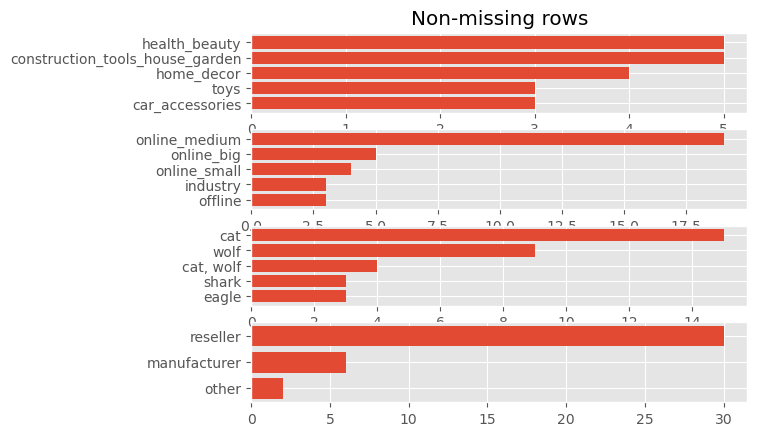

In [22]:
# Plots of top 5 most frequent for business segment, lead_type, lead_behaviour_profile, business_type
plt.subplot(4,1,1)
plt.barh(y=no_missing['business_segment'].value_counts()[:5][::-1].index, width=no_missing['business_segment'].value_counts()[:5][::-1])
plt.title("Non-missing rows")
plt.subplot(4,1,2)
plt.barh(y=no_missing['lead_type'].value_counts()[:5][::-1].index, width=no_missing['lead_type'].value_counts()[:5][::-1])
plt.subplot(4,1,3)
plt.barh(y=no_missing['lead_behaviour_profile'].value_counts()[:5][::-1].index, width=no_missing['lead_behaviour_profile'].value_counts()[:5][::-1])
plt.subplot(4,1,4)
plt.barh(y=no_missing['business_type'].value_counts()[:5][::-1].index, width=no_missing['business_type'].value_counts()[:5][::-1])
plt.show()

- Overall, the distributions of business segment, lead_type, lead_behaviour_profile, and business_type is very similar across all three subgroups

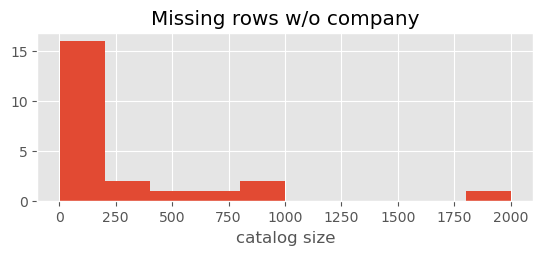

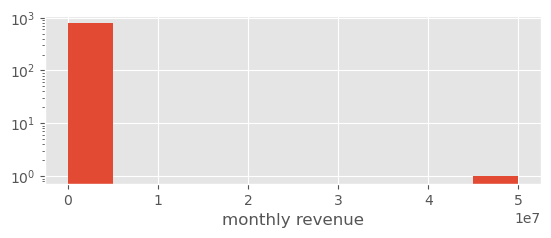

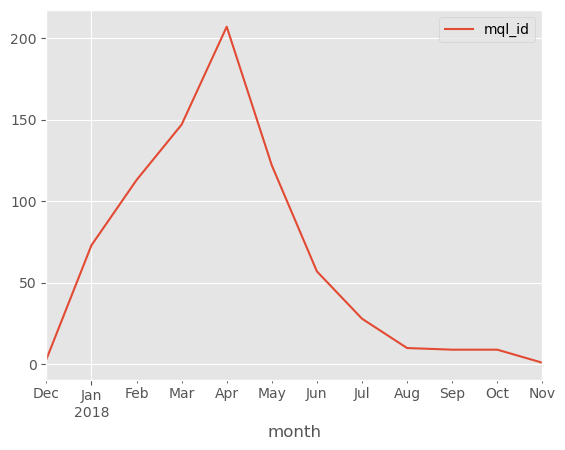

In [23]:
# graphs for product catalog size, monthly revenue, and won dates
# histogram of product catalog sizes
plt.subplot(2,1,1)
plt.hist(missing_company['declared_product_catalog_size'])
plt.xlabel('catalog size')
plt.title("Missing rows w/o company")
plt.show()

# histogram of monthly revenue
plt.subplot(2,1,2)
plt.hist(missing_company['declared_monthly_revenue'])
plt.yscale('log')
plt.xlabel('monthly revenue')
plt.show()

# time series of won dates (monthly)
monthly_stats = missing_company.groupby('month').count()
monthly_stats.plot(y='mql_id')
plt.show()

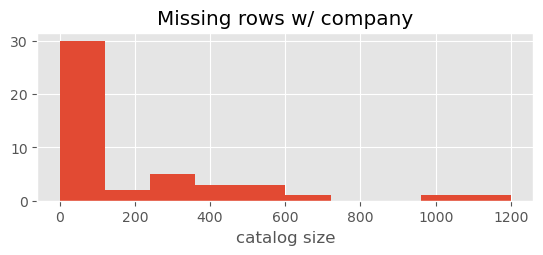

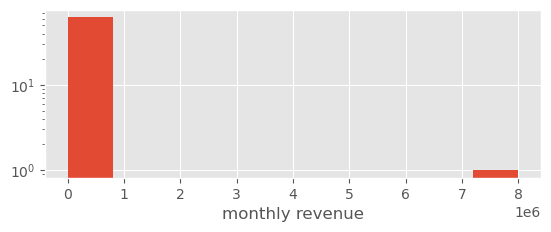

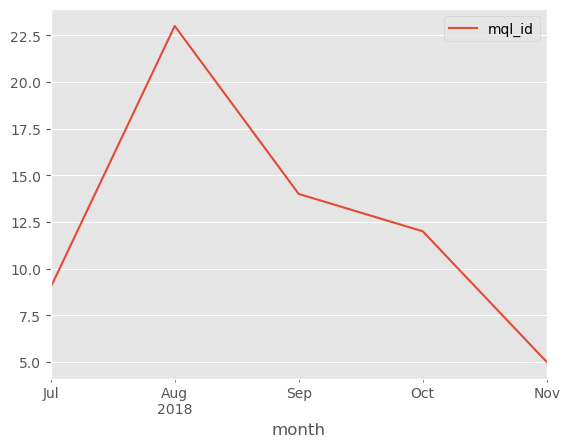

In [24]:
# graphs for product catalog size, monthly revenue, and won dates
# histogram of product catalog sizes
plt.subplot(2,1,1)
plt.hist(missing_other['declared_product_catalog_size'])
plt.xlabel('catalog size')
plt.title("Missing rows w/ company")
plt.show()

# histogram of monthly revenue
plt.subplot(2,1,2)
plt.hist(missing_other['declared_monthly_revenue'])
plt.yscale('log')
plt.xlabel('monthly revenue')
plt.show()

# time series of won dates (monthly)
monthly_stats = missing_other.groupby('month').count()
monthly_stats.plot(y='mql_id')
plt.show()

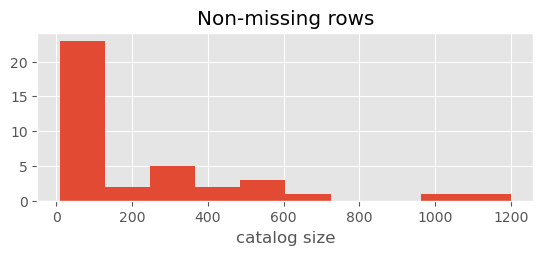

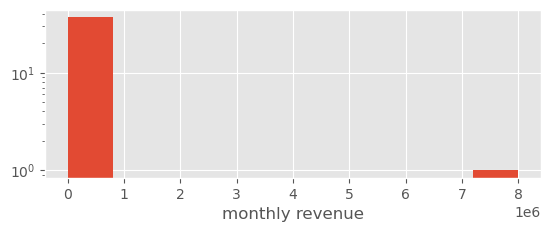

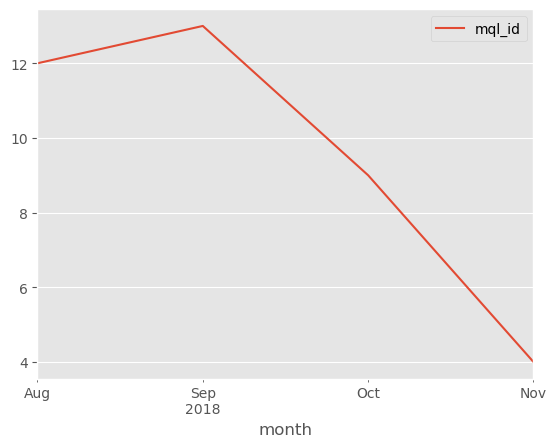

In [25]:
# graphs for product catalog size, monthly revenue, and won dates
# histogram of product catalog sizes
plt.subplot(2,1,1)
plt.hist(no_missing['declared_product_catalog_size'])
plt.xlabel('catalog size')
plt.title("Non-missing rows")
plt.show()

# histogram of monthly revenue
plt.subplot(2,1,2)
plt.hist(no_missing['declared_monthly_revenue'])
plt.yscale('log')
plt.xlabel('monthly revenue')
plt.show()

# time series of won dates (monthly)
monthly_stats = no_missing.groupby('month').count()
monthly_stats.plot(y='mql_id')
plt.show()

In [26]:
print(no_missing.shape)
print(missing_other.shape)
print(missing_company.shape)

(38, 15)
(63, 15)
(779, 15)


Results:
- Mostly similar trends except for `won_date`
- rows with missing value:
    - with company: after July 2018
    - without company: 2017-2018
- rows with no missing values: after Aug 2018

## Conclusion:
### Handling of missing values
- Divided the `mql` and `closed_deals` between rows with and without missing values and compared trends to see any differences
- Found:
    - for `mql` dataset, similar trends.
        - missing values are insignificant
    - for `closed_deals` dataset, similar trends except for `won_date`
        - Out of the rows with missing values, the ones without a company spread between 2017 and 2018
        - While, of those with a company, the `won_date` are after July 2018
        - For rows with no missing values, the `won_date` is after August 2018
        - This may become important in later analysis
### Profile:
- Most of the customers (of Olist) are likely individual vendors because:
    - they do not have a company
    - have no declared revenue
- Most are resellers, instead of manufacturers
- Overall, the customers of Olist,
    - are concentrated in small scaled vendors that resell products